### Movie Ratings Project

First import important modules and data files for movies and ratings by users

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.sparse import csr_matrix

movies = pd.read_csv('ml-latest-small/movies.csv')
ratings = pd.read_csv('ml-latest-small/ratings.csv')

Lets explore some data in both movies and ratings

In [8]:
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [3]:
ratings.head()

,userId,movieId,rating,timestamp
0,1,31,2.5,1260759144
1,1,1029,3.0,1260759179
2,1,1061,3.0,1260759182
3,1,1129,2.0,1260759185
4,1,1172,4.0,1260759205


In [5]:
# total records in each dataset
print('records in movies {} and records in ratings {}'.format(len(movies), len(ratings)))
#print('records in movies {} and records in ratings {}'.format(movies.shape[0], ratings.shape[0]))

records in movies 9125 and records in ratings 100004


Create a function which will gives romance and scifi average rating by each users

In [30]:
def get_genre_ratings(ratings, movies, genres, avg_column_names):
    genere_ratings = pd.DataFrame()
    for genre in genres:
        genre_movie = movies[movies['genres'].str.contains(genre)]
        avg_vote_per_user_per_genre = ratings[ratings['movieId'].isin(genre_movie['movieId'])].loc[:, ['userId', 'rating']].groupby(['userId'])['rating'].mean().round(2)
        #print(avg_vote_per_user_per_genre)
        genere_ratings = pd.concat([genere_ratings, avg_vote_per_user_per_genre], axis=1)
    
    genere_ratings.columns = avg_column_names
    return genere_ratings

Now we will call above function on our dataset for romance and scifi movies avg rating by each users

In [95]:
genre_ratings = get_genre_ratings(ratings, movies, ['Romance', 'Sci-Fi'], ['avg_romance_rating', 'avg_scifi_rating'])
genre_ratings.head()

,avg_romance_rating,avg_scifi_rating
userId,,
1,3.50,2.40
2,3.59,3.80
3,3.65,3.14
4,4.50,4.26
5,4.08,4.00


Now we will remove those users who voted good for both movies, so our dataste have only one sided users. Lets create one biased data set

In [96]:
def bias_genre_rating(genre_ratings, limit_1, limit_2):
    biased_set = genre_ratings[((genre_ratings['avg_romance_rating'] < limit_1) & (genre_ratings['avg_scifi_rating'] > limit_2)) | ((genre_ratings['avg_romance_rating'] > limit_2) & (genre_ratings['avg_scifi_rating'] < limit_1))]
    return biased_set

In [97]:
biased_dataset= bias_genre_rating(genre_ratings, 3.2, 2.5)
print('number of records in baised dataset: {}'.format(len(biased_dataset)))
biased_dataset.head()

number of records in baised dataset: 206


,avg_romance_rating,avg_scifi_rating
userId,,
1,3.50,2.40
3,3.65,3.14
6,2.90,2.75
7,2.93,3.36
12,2.89,2.62



Now we plot our both genre_rating dataset and biased_dataset using out helper moudle

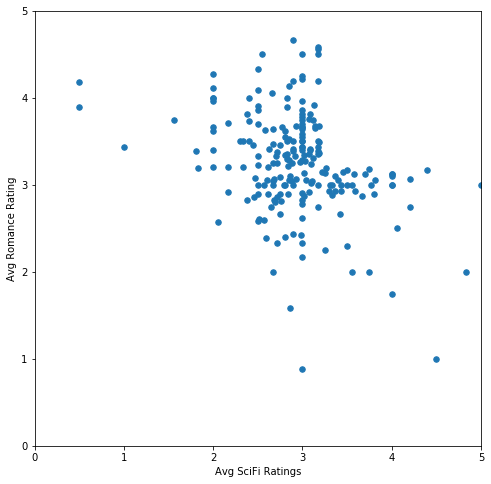

In [98]:
import helper

helper.draw_scatterplot(biased_dataset['avg_scifi_rating'], 'Avg SciFi Ratings', biased_dataset['avg_romance_rating'], 'Avg Romance Rating')

#####  Figure 1

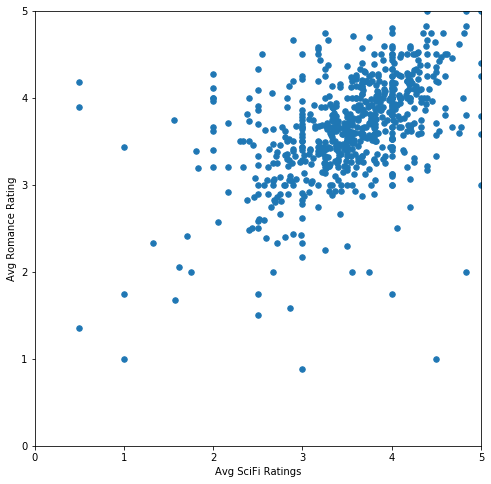

In [99]:
helper.draw_scatterplot(genre_ratings['avg_scifi_rating'], 'Avg SciFi Ratings', genre_ratings['avg_romance_rating'], 'Avg Romance Rating')



##### Figure 2


So from above two figures you can see why we made biased dataset, as most of the user from figure 2 have voted high for both the genres movies. So figure 2 is our biased sample where one user more like one genre movies then other.

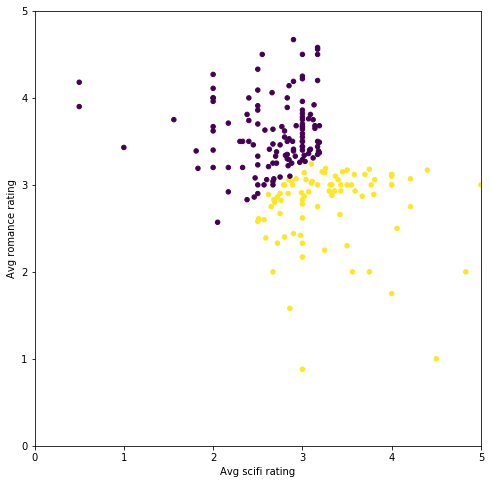

In [100]:
# COnvert our biased dataset to list
X = biased_dataset[['avg_scifi_rating', 'avg_romance_rating']].values

# Create clusters using K-means
from sklearn.cluster import KMeans

kmeans_1 = KMeans(n_clusters = 2)

predictions = kmeans_1.fit_predict(X)

# plot
helper.draw_clusters(biased_dataset, predictions)

Here we can see that the groups are created on the basis of how users rated romance movies (as y-axis shows a demarcation line at y = 3). If movie romance rating is 3 or greater then it is a romantic movie. Otherwise scifi movie. 

Let's see this with 3 clusters

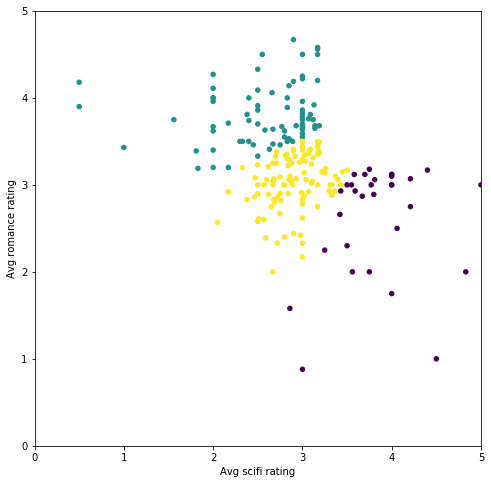

In [105]:
kmeans_2 = KMeans(n_clusters = 3)

predictions_2 = kmeans_2.fit_predict(X)

# plot
helper.draw_clusters(biased_dataset, predictions_2)

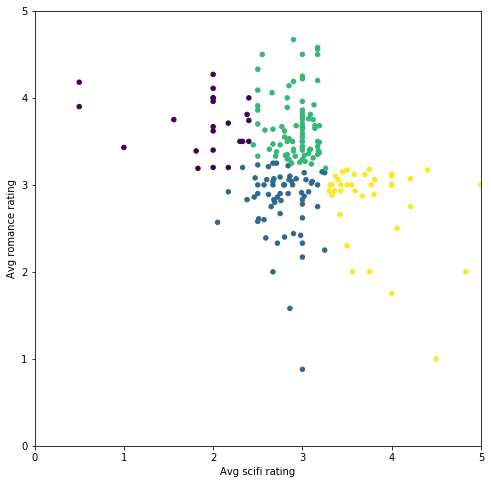

In [106]:
kmeans_3 = KMeans(n_clusters = 4)

predictions_3 = kmeans_3.fit_predict(X)

# plot
helper.draw_clusters(biased_dataset, predictions_3)

Let's see how to choose K values. We will do it by caluclating error which is the sum of square of distance between cluster centroid and data point belong to that centroid cluster. Lets create a function which use silhouette_score.

In [107]:
from sklearn.metrics import silhouette_score

def cluster_error(k, data):
    m = KMeans(n_clusters = k).fit(data)
    predicts = m.predict(data)
    sil_avg = silhouette_score(data, predicts)
     
    return sil_avg

In [109]:
# Choose a range of K values to find best one among them with a gap of 5 step as we don't want to estimate for each data point
possible_k_val = range(2,len(X)+1,5)
error_per_k_val = [cluster_error(k, X) for k in possible_k_val]

list(zip(possible_k_val,error_per_k_val))

[(2, 0.3455136344437441),
 (7, 0.3994721357749664),
 (12, 0.3438813018273758),
 (17, 0.37696651070544523),
 (22, 0.36030504389701795),
 (27, 0.36610953169952076),
 (32, 0.3805319556324505),
 (37, 0.34645063579187246),
 (42, 0.3669184815708991),
 (47, 0.36724143023277994),
 (52, 0.3779711370529432),
 (57, 0.36954443571507417),
 (62, 0.35929608728289814),
 (67, 0.33955138116448585),
 (72, 0.3499718898648521),
 (77, 0.343297611092307),
 (82, 0.3517991613210364),
 (87, 0.34796509176434504),
 (92, 0.33913053461963505),
 (97, 0.3508924702379608),
 (102, 0.340840568644128),
 (107, 0.3412489562110246),
 (112, 0.3273026384233453),
 (117, 0.3279509471549261),
 (122, 0.31288930229135825),
 (127, 0.31542060440050346),
 (132, 0.2963653639015556),
 (137, 0.28689690799181056),
 (142, 0.27860649895291406),
 (147, 0.25411344576529066),
 (152, 0.24913722915225958),
 (157, 0.22982847380073604),
 (162, 0.21655399052027102),
 (167, 0.19788233071923392),
 (172, 0.18929002869609746),
 (177, 0.167720848985925

Now plot a graph of number of clusters vs error

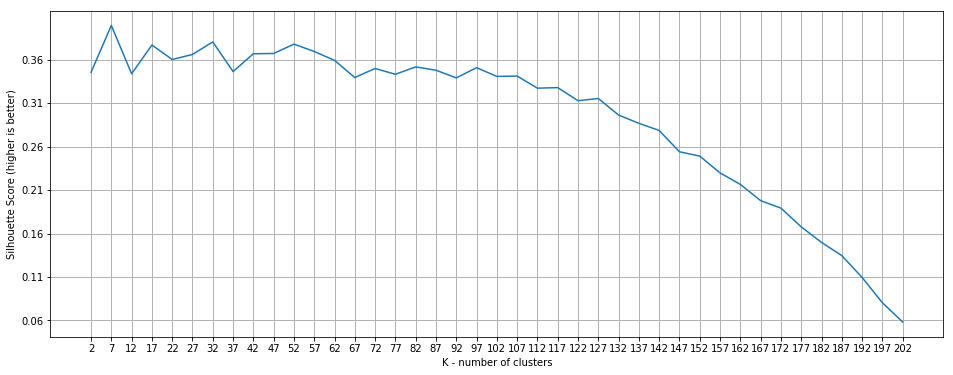

In [111]:
fig, ax = plt.subplots(figsize=(16, 6))
ax.set_xlabel('K - number of clusters')
ax.set_ylabel('Silhouette Score (higher is better)')
ax.plot(possible_k_val, error_per_k_val)

# Ticks and grid
xticks = np.arange(min(possible_k_val), max(possible_k_val)+1, 5.0)
ax.set_xticks(xticks, minor=False)
ax.set_xticks(xticks, minor=True)
ax.xaxis.grid(True, which='both')
yticks = np.arange(round(min(error_per_k_val), 2), max(error_per_k_val), .05)
ax.set_yticks(yticks, minor=False)
ax.set_yticks(yticks, minor=True)
ax.yaxis.grid(True, which='both')

Here we can see for k=7 we are getting higher score (that means lower error). Let's make one prediction for k=7.

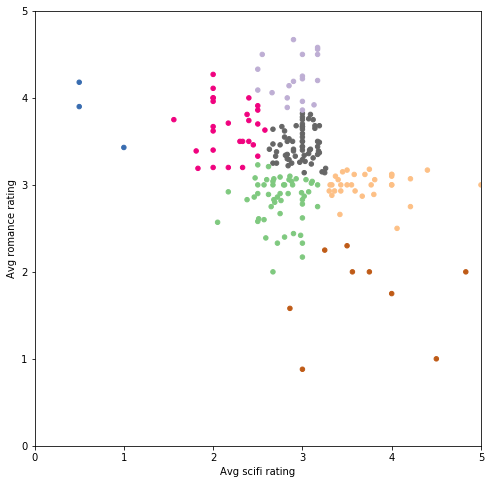

In [114]:
kmeans_4 = KMeans(n_clusters = 7)

predictions_4 = kmeans_4.fit_predict(X)

# plot use cmap='Accent' for better output
helper.draw_clusters(biased_dataset, predictions_4, cmap='Accent')


In [117]:
genre_with_action = get_genre_ratings(ratings, movies, ['Romance', 'Sci-Fi', 'Action'], ['avg_romance_rating', 'avg_scifi_rating', 'avg_action_rating'])
genre_with_action.head()

,avg_romance_rating,avg_scifi_rating,avg_action_rating
userId,,,
1,3.50,2.40,2.80
2,3.59,3.80,3.32
3,3.65,3.14,3.47
4,4.50,4.26,4.27
5,4.08,4.00,4.00


In [131]:
# Create biased dataset with same setting for Romance and Scifi. Note drop the NA values for actions
biased_dataset_3_geners = bias_genre_rating(genre_with_action, 3.2, 2.5)
print('Now records:', len(biased_dataset_3_geners))
biased_dataset_3_geners.head()

Now records: 206


,avg_romance_rating,avg_scifi_rating,avg_action_rating
userId,,,
1,3.50,2.40,2.80
3,3.65,3.14,3.47
6,2.90,2.75,3.27
7,2.93,3.36,3.29
12,2.89,2.62,3.21


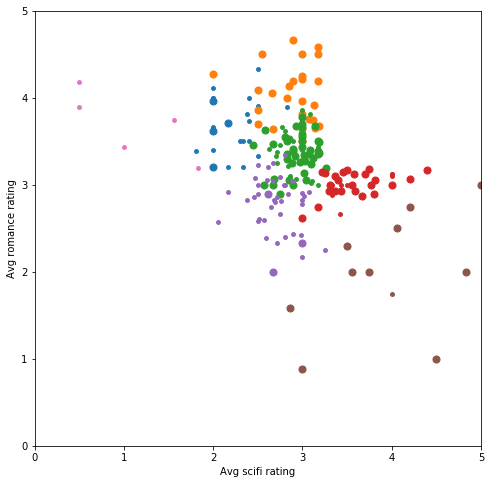

In [135]:
X_with_action = biased_dataset_3_geners[['avg_scifi_rating', 'avg_romance_rating', 'avg_action_rating']].values

kmeans_5 = KMeans(n_clusters = 7)

predictions_5 = kmeans_5.fit_predict(X_with_action)

# plot use draw_clusters_3d from helper moudle
helper.draw_clusters_3d(biased_dataset_3_geners, predictions_5)


Now we have 3 features and we can see how more similar the taste of people in each group. But suppose we have more feature like Drama, Horror, etc. So will we be able to catch them in such scattreplots. Maybe not. So if we move to more dimensions then it would be hard for us to visualise better if we keep on doing like this. 

Lets have other way of doing such visualisation.

Before that lets see how each movie is rated by users. We will tweak data like userId vs rating for each movie.

In [141]:
ratings_titles = pd.merge(ratings, movies[['movieId', 'title']], on = 'movieId')
user_movie_ratings = pd.pivot_table(ratings_titles, index = 'userId', columns = 'title', values = 'rating')

print('Data dimension {}'.format(user_movie_ratings.shape))
user_movie_ratings.iloc[:6,:10]

Data dimension (671, 9064)


title,"""Great Performances"" Cats (1998)",$9.99 (2008),'Hellboy': The Seeds of Creation (2004),'Neath the Arizona Skies (1934),'Round Midnight (1986),'Salem's Lot (2004),'Til There Was You (1997),"'burbs, The (1989)",'night Mother (1986),(500) Days of Summer (2009)
userId,,,,,,,,,,
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,NaN,NaN


As most of the movies are not rated by users so we have NaN values. Lets get most rated movies and users who gave most rated movies. And will do our analysis on it.

See below example to understand the code better

In [181]:
df = pd.DataFrame({
    'col1': ['A', 'A', 'B', np.nan, 'D', 'C'],
    'col2': [2, 1, 9, 8, 7, 4],
    'col3': [0, 1, 9, 4, 2, 3],
})

print('Dataframe is: \n', df)
print('***************************')
df = df.append(df.count(), ignore_index=True)
print('Dataframe after adding count of each column: \n',df)
print('***************************')
print('Dataframe after sorting along columns: \n')
temp = df.sort_values(len(df)-1, axis=1, ascending=False)
print(temp)
print('***************************')
print('Dataframe after removing count column appedned initially: \n')
temp2 = temp.drop(temp.tail(1).index)
print(temp2)

Dataframe is: 
   col1  col2  col3
0    A     2     0
1    A     1     1
2    B     9     9
3  NaN     8     4
4    D     7     2
5    C     4     3
***************************
Dataframe after adding count of each column: 
   col1  col2  col3
0    A     2     0
1    A     1     1
2    B     9     9
3  NaN     8     4
4    D     7     2
5    C     4     3
6    5     6     6
***************************
Dataframe after sorting along columns: 

   col2  col3 col1
0     2     0    A
1     1     1    A
2     9     9    B
3     8     4  NaN
4     7     2    D
5     4     3    C
6     6     6    5
***************************
Dataframe after removing count column appedned initially: 

   col2  col3 col1
0     2     0    A
1     1     1    A
2     9     9    B
3     8     4  NaN
4     7     2    D
5     4     3    C


In [187]:
def get_most_rated_movies(user_movie_ratings, n_movies):
    # 1st we do count of ratings in each movie
    user_movie_ratings_counted = user_movie_ratings.append(user_movie_ratings.count(), ignore_index = True)
    # 2nd we sort the movies which have highest ratings
    user_movie_ratings_sorted = user_movie_ratings_counted.sort_values(len(user_movie_ratings_counted)-1, axis=1, ascending=True)
    # 3rd remove row append in 1st step
    user_movie_ratings_sorted = user_movie_ratings_sorted.drop(user_movie_ratings_sorted.tail(1).index)
    
    most_rated_movies = user_movie_ratings_sorted.iloc[:, :n_movies]
    return most_rated_movies

def get_users_who_rate_the_most(most_rated_movies, n_users):
    # counts number of movies in each row and adda column at the end
    most_rated_movies['counts'] = pd.Series(most_rated_movies.count(axis=1))
    # Sort the dataframe according to rows on count column
    most_rated_movies_sorted = most_rated_movies.sort_values('counts', axis=0, ascending=False)
    # Select the required number of top most rate users
    most_rated_movies_by_most_users = most_rated_movies_sorted.iloc[:n_users, :]
    # Drop the count column
    most_rated_movies_by_most_users = most_rated_movies_by_most_users.drop('counts', axis = 1)
    
    return most_rated_movies_by_most_users
    
    

we want top 30 movies rated by top 18 users

In [196]:
n_movies = 30
n_users = 18
most_rated_movies = get_most_rated_movies(user_movie_ratings, n_movies)
#most_rated_movies.shape
most_rated_movies_users_selection = get_users_who_rate_the_most(most_rated_movies, n_users)
most_rated_movies_users_selection.head()

title,Forrest Gump (1994),Pulp Fiction (1994),"Shawshank Redemption, The (1994)","Silence of the Lambs, The (1991)",Star Wars: Episode IV - A New Hope (1977),Jurassic Park (1993),"Matrix, The (1999)",Toy Story (1995),Schindler's List (1993),Terminator 2: Judgment Day (1991),...,Dances with Wolves (1990),Fight Club (1999),"Usual Suspects, The (1995)",Seven (a.k.a. Se7en) (1995),"Lion King, The (1994)","Godfather, The (1972)","Lord of the Rings: The Fellowship of the Ring, The (2001)",Apollo 13 (1995),True Lies (1994),Twelve Monkeys (a.k.a. 12 Monkeys) (1995)
29,5.0,5.0,5.0,4.0,4.0,4.0,3.0,4.0,5.0,4.0,...,5.0,4.0,5.0,4.0,3.0,5.0,3.0,5.0,4.0,2.0
508,4.0,5.0,4.0,4.0,5.0,3.0,4.5,3.0,5.0,2.0,...,5.0,4.0,5.0,4.0,3.5,5.0,4.5,3.0,2.0,4.0
14,1.0,5.0,2.0,5.0,5.0,3.0,5.0,2.0,4.0,4.0,...,3.0,5.0,5.0,5.0,4.0,5.0,5.0,3.0,4.0,4.0
72,5.0,5.0,5.0,4.5,4.5,4.0,4.5,5.0,5.0,3.0,...,4.5,5.0,5.0,5.0,5.0,5.0,5.0,3.5,3.0,5.0
653,4.0,5.0,5.0,4.5,5.0,4.5,5.0,5.0,5.0,5.0,...,4.5,5.0,5.0,4.5,5.0,4.5,5.0,5.0,4.0,5.0


Let's visualise it with broder way 

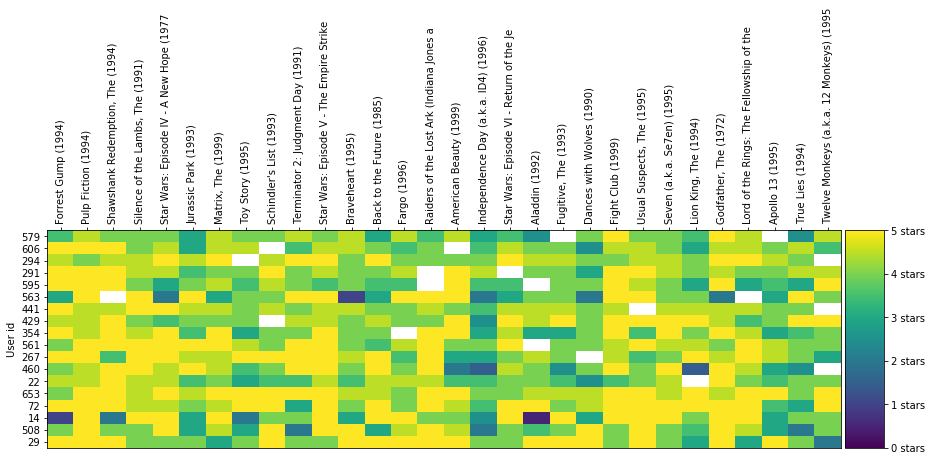

In [197]:
helper.draw_movies_heatmap(most_rated_movies_users_selection)

The whites spaces in above heatmap shows how some users didn't rate these movies. And this is how real life data looks like and can be more often sparse. And due to this directly clustering users based on there movie ratings is not something like by K-Means.

We will do for 1ooo movies out of 9000+

In [214]:
most_rated_movies_1k = get_most_rated_movies(user_movie_ratings, 1000)
sparse_ratings = csr_matrix(pd.SparseDataFrame(most_rated_movies_1000).to_coo())

In [228]:
# We will do prediction on k=20
predictions = KMeans(n_clusters=20, algorithm='full').fit_predict(sparse_ratings)


To visualize these prediction with different clusters. We will plot them in heat map. The prediction for each cluster would be different which depends on how the centroids are assigned.

C:\Users\ayush.saxena\Desktop\Practice\K_means\helper.py:115: FutureWarning: '.reindex_axis' is deprecated and will be removed in a future version. Use '.reindex' instead.
  d = d.reindex_axis(d.mean().sort_values(ascending=False).index, axis=1)
C:\Users\ayush.saxena\Desktop\Practice\K_means\helper.py:116: FutureWarning: '.reindex_axis' is deprecated and will be removed in a future version. Use '.reindex' instead.
  d = d.reindex_axis(d.count(axis=1).sort_values(ascending=False).index)
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\cbook\deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


cluster # 15
# of users in cluster: 263. # of users in plot: 70


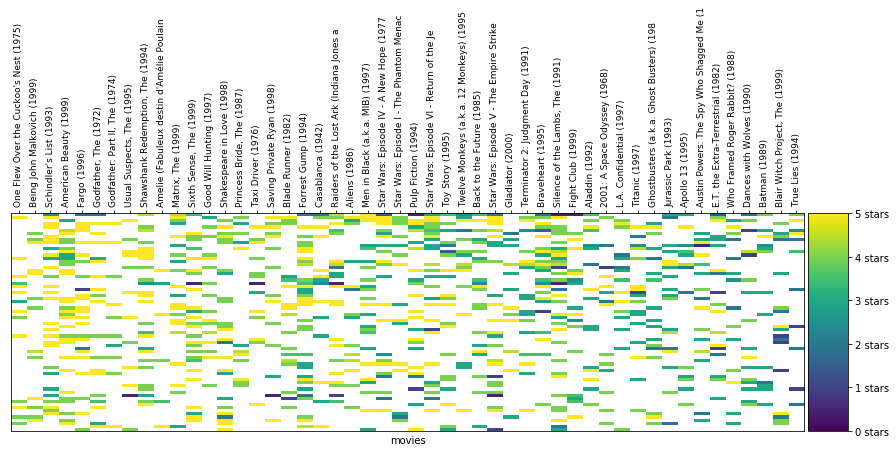

cluster # 1
# of users in cluster: 83. # of users in plot: 70


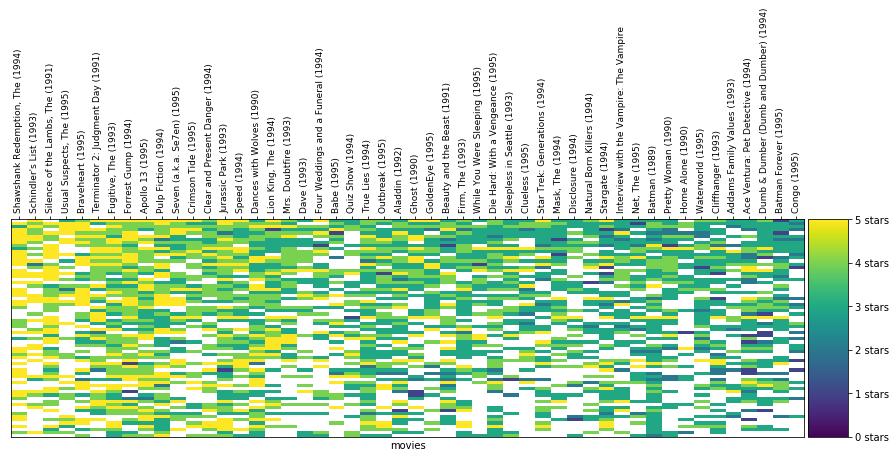

cluster # 0
# of users in cluster: 23. # of users in plot: 23


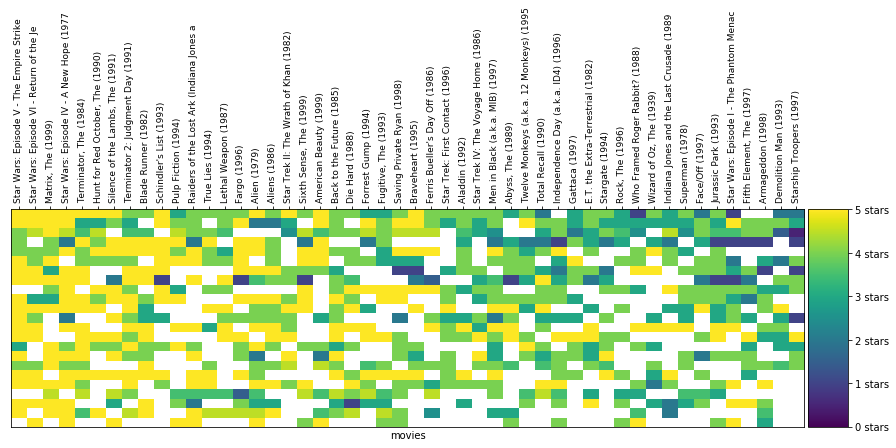

cluster # 3
# of users in cluster: 55. # of users in plot: 55


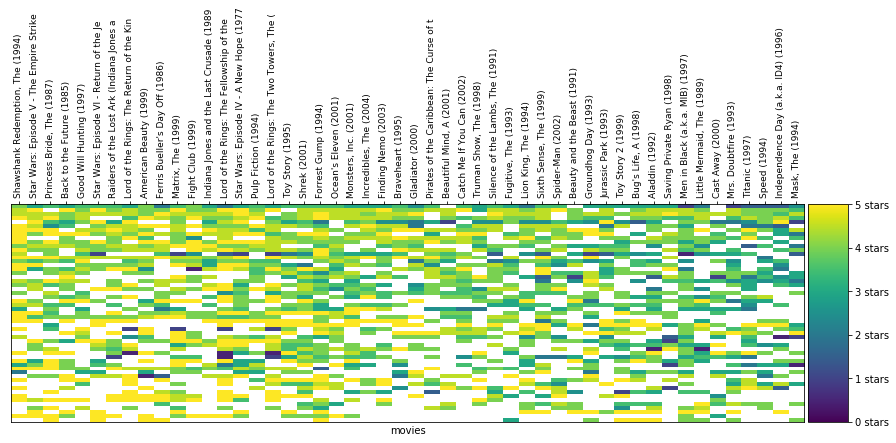

cluster # 14
# of users in cluster: 72. # of users in plot: 70


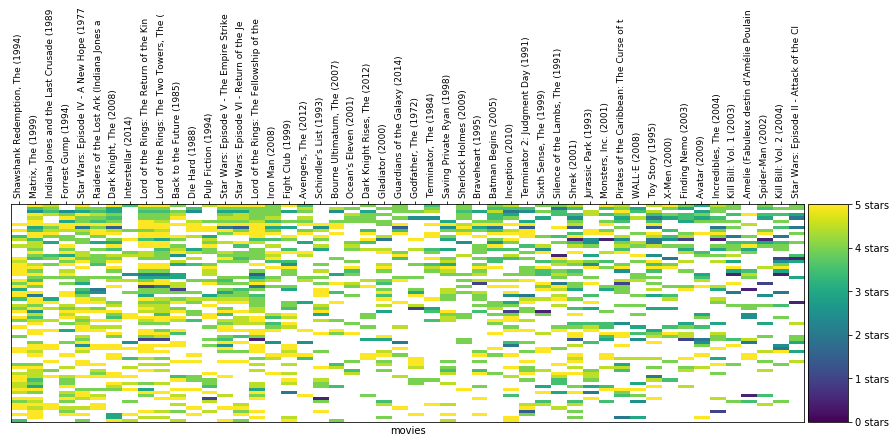

cluster # 19
# of users in cluster: 10. # of users in plot: 10


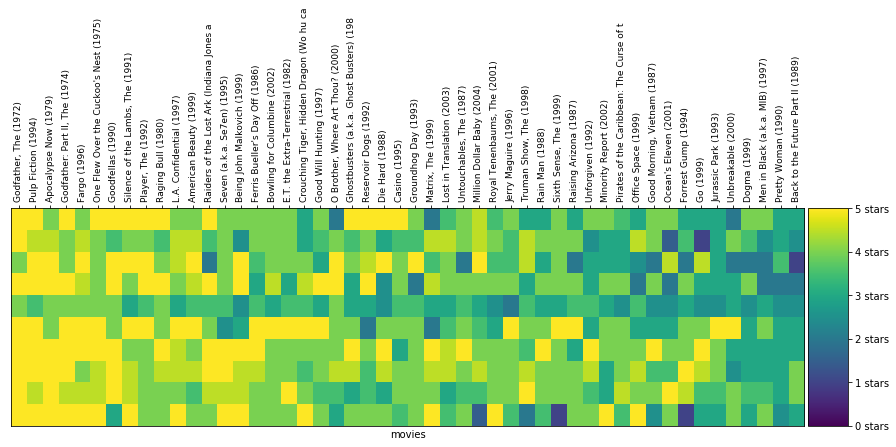

cluster # 2
# of users in cluster: 45. # of users in plot: 45


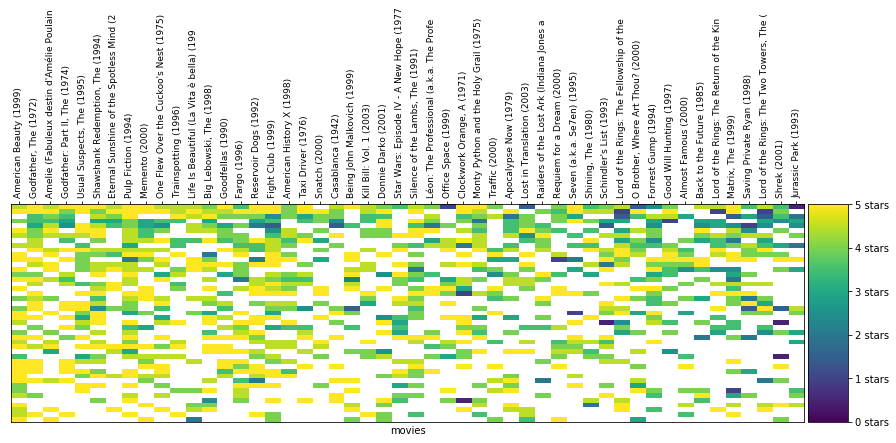

cluster # 9
# of users in cluster: 38. # of users in plot: 38


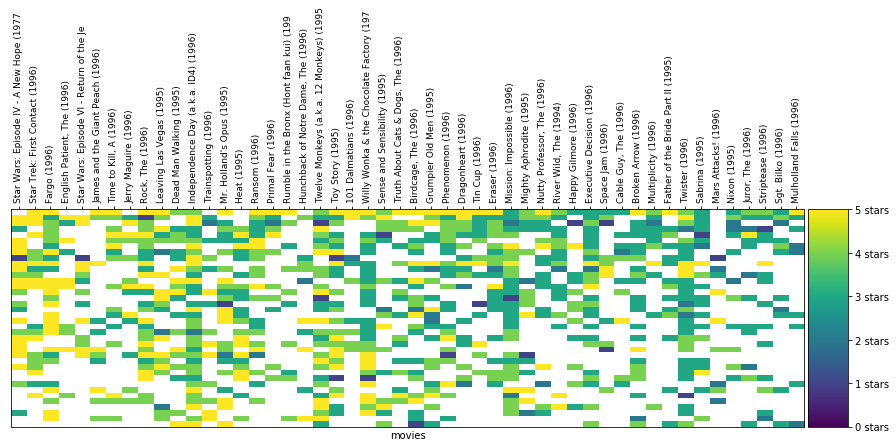

cluster # 12
# of users in cluster: 20. # of users in plot: 20


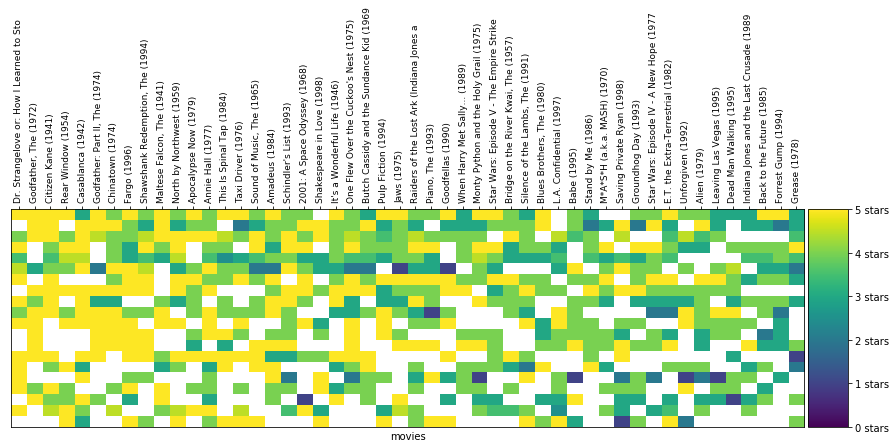

cluster # 8
# of users in cluster: 25. # of users in plot: 25


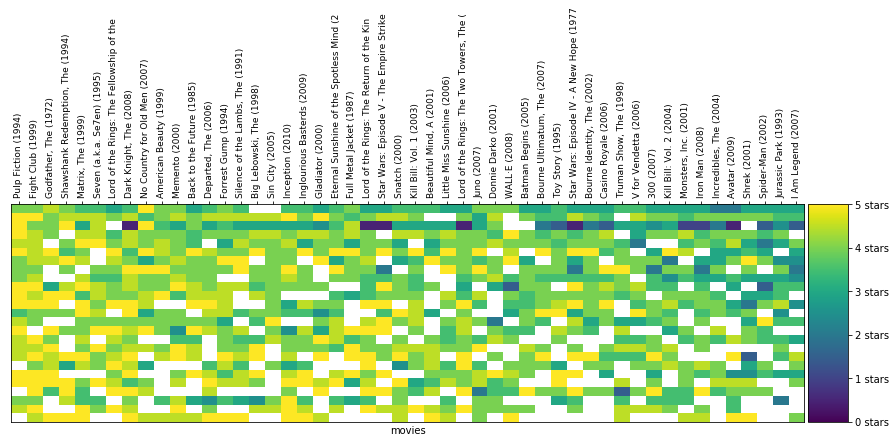

cluster # 5
# of users in cluster: 17. # of users in plot: 17


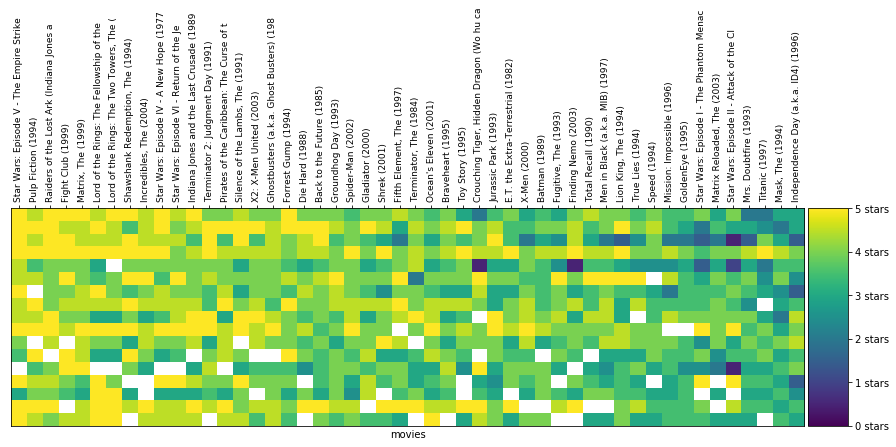

In [216]:

max_users = 70
max_movies = 50

clustered = pd.concat([most_rated_movies_1k.reset_index(), pd.DataFrame({'group':predictions})], axis=1)
helper.draw_movie_clusters(clustered, max_users, max_movies)

In [240]:
clustered.columns    


Index(['index', 'Forrest Gump (1994)', 'Pulp Fiction (1994)',
       'Shawshank Redemption, The (1994)', 'Silence of the Lambs, The (1991)',
       'Star Wars: Episode IV - A New Hope (1977)', 'Jurassic Park (1993)',
       'Matrix, The (1999)', 'Toy Story (1995)', 'Schindler's List (1993)',
       ...
       'What Lies Beneath (2000)', 'Roman Holiday (1953)',
       'Motorcycle Diaries, The (Diarios de motocicleta) (2004)',
       'Sophie's Choice (1982)', 'Dawn of the Dead (2004)',
       'Ocean's Thirteen (2007)', 'Seabiscuit (2003)', 'Easy Rider (1969)',
       'Lucky Number Slevin (2006)', 'group'],
      dtype='object', length=1002)

So we have all clusters with different predictions, where it make the groups of users of similar taste or similar ratings.
Lets see the output of 1 cluster

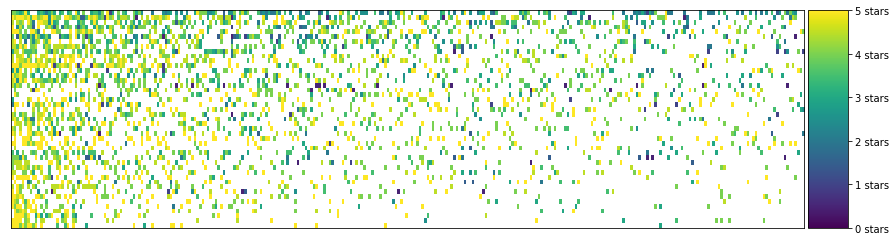

In [264]:
cluster_number = 2

n_user = 75
n_movies = 300
cluster = clustered[clustered.group == cluster_number].drop(['index', 'group'], axis = 1)
cluster = helper.sort_by_rating_density(cluster, n_movies, n_user)
helper.draw_movies_heatmap(cluster, axis_labels=False)

In [265]:
# Actual ratings in the cluster looks like
cluster.fillna('').head()

,Pulp Fiction (1994),American Beauty (1999),Fight Club (1999),"Shawshank Redemption, The (1994)","Godfather, The (1972)","Silence of the Lambs, The (1991)",Reservoir Dogs (1992),Fargo (1996),"Matrix, The (1999)","Usual Suspects, The (1995)",...,My Neighbor Totoro (Tonari no Totoro) (1988),True Romance (1993),Home Alone (1990),WALL·E (2008),Heavenly Creatures (1994),"City of Lost Children, The (Cité des enfants perdus, La) (1995)","Exorcist, The (1973)","Thin Red Line, The (1998)",Gosford Park (2001),Star Wars: Episode I - The Phantom Menace (1999)
17,4,4,3.5,3,3.5,5,3,,,,...,2.5,,4,2,4,3,2.5,,,
0,5,4.5,5,5,5,4.5,5,3.5,5,5,...,,4,,,2,4.5,4,,,
29,4.5,,4.5,4,4.5,,5,4,2,,...,,,,,5,,,,,
44,5,,2.5,4.5,3.5,,4,4,1.5,,...,,3.5,2,,,,,,,
28,5,5,5,4,,4,,5,5,4,...,,,,,,,,,5,4


In [266]:
#lets find some info about userId = 61 for Batman movie
movie_name = "Batman (1989)"
cluster[movie_name].mean()

3.2142857142857144

from our K-means clustering algorithm for cluster = 1, we can say the userId = 61 can give 3.22 rating to Batman (1989).

And the average of each movie will be:


In [267]:
cluster.mean().head(20)

Pulp Fiction (1994)                                          4.402778
American Beauty (1999)                                       4.632353
Fight Club (1999)                                            4.242424
Shawshank Redemption, The (1994)                             4.419355
Godfather, The (1972)                                        4.551724
Silence of the Lambs, The (1991)                             4.160714
Reservoir Dogs (1992)                                        4.267857
Fargo (1996)                                                 4.285714
Matrix, The (1999)                                           3.722222
Usual Suspects, The (1995)                                   4.425926
Big Lebowski, The (1998)                                     4.296296
One Flew Over the Cuckoo's Nest (1975)                       4.340000
Memento (2000)                                               4.354167
Monty Python and the Holy Grail (1975)                       4.104167
Forrest Gump (1994) 

Now it is very useful for us, now we can use it as recommendation engine that enabls our users to discover movies they are likely to enjoy. 

The formula for these recommendation is to select the cluster's highest-rated movies that the user did not rate yet.

In [268]:
user_id = 27
user_19_ratings = cluster.loc[user_id, :]
user_19_not_rated = user_19_ratings[user_19_ratings.isnull()]
#print(user_19_not_rated)
avg_ratings_19 = pd.concat([user_19_not_rated, cluster.mean()], axis=1, join='inner').loc[:,0]
avg_ratings_19.sort_values(ascending=False)[:20]

Wallace & Gromit: A Close Shave (1995)                                       4.714286
Boogie Nights (1997)                                                         4.687500
Rushmore (1998)                                                              4.687500
Burn After Reading (2008)                                                    4.666667
Boot, Das (Boat, The) (1981)                                                 4.600000
Chinatown (1974)                                                             4.600000
Bridge on the River Kwai, The (1957)                                         4.600000
L.A. Confidential (1997)                                                     4.555556
Godfather, The (1972)                                                        4.551724
12 Angry Men (1957)                                                          4.545455
Amelie (Fabuleux destin d'Amélie Poulain, Le) (2001)                         4.523810
Great Escape, The (1963)                              